In [24]:
import numpy as np
import pandas as pd
import math
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM,GRU,Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import sklearn.metrics as metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
# fix random seed for reproducibility
np.random.seed(1)
tf.random.set_seed(1) 
random.seed(1)

# read data from files to dataframes
df1 = pd.read_csv("./Traffic_Data_cali/train.csv", encoding='utf-8')
df2 = pd.read_csv("./Traffic_Data_cali/test.csv", encoding='utf-8')

# normalize data
scaler = MinMaxScaler(feature_range=(0, 1)).fit(df1['Flow (Veh/5 Minutes)'].values.reshape(-1, 1))
train_data = scaler.transform(df1['Flow (Veh/5 Minutes)'].values.reshape(-1, 1)).reshape(1, -1)[0]
test_data = scaler.transform(df2['Flow (Veh/5 Minutes)'].values.reshape(-1, 1)).reshape(1, -1)[0]

# practicing with different time lag (look back) values to optimize the models
lag = 12
train, test = [], []
for i in range(lag, len(train_data)):
    train.append(train_data[i - lag: i + 1])
for i in range(lag, len(test_data)):
    test.append(test_data[i - lag: i + 1])

train = np.array(train)
test = np.array(test)
# shuffle data (stateles case)
np.random.shuffle(train)
x_train = train[:, :-1]
y_train = train[:, -1]
x_test = test[:, :-1]
y_test = test[:, -1]

In [31]:
# building models

def build_LSTM():
    model = Sequential()
    model.add(LSTM(64,input_shape=(lag, 1),return_sequences=True))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model    

def build_GRU():
    model = Sequential()
    model.add(GRU(64, input_shape=(lag, 1), return_sequences=True))
    model.add(GRU(64))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# model_struct = "LSTM"
model_struct = "GRU"
#model_struct = "AE"
# train the models 
if model_struct == "LSTM" :
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    model = build_LSTM()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['mape'])
    monitor = EarlyStopping(monitor='val_loss', patience=40, verbose=1, mode='auto',restore_best_weights=True)
    hist = model.fit(x_train, y_train,batch_size=64,epochs=600,callbacks=[monitor],validation_split=0.05)
    model.save('models/LSTM.h5')
    df = pd.DataFrame.from_dict(hist.history)
    df.to_csv('models/LSTM_loss.csv', encoding='utf-8', index=False)        
elif model_struct == "GRU" :        
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    model = build_GRU()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['mape'])
    monitor = EarlyStopping(monitor='val_loss', patience=40, verbose=1, mode='auto',restore_best_weights=True)
    hist = model.fit(x_train, y_train,batch_size=64,epochs=600,callbacks=[monitor],validation_split=0.05)
    model.save('models/GRU.h5')
    df = pd.DataFrame.from_dict(hist.history)
    df.to_csv('models/GRU_loss.csv', encoding='utf-8', index=False)


Epoch 1/600
116/116 [==============================] - 4s 15ms/step - loss: 0.0128 - mape: 94848.2266 - val_loss: 0.0083 - val_mape: 94222.7734
Epoch 2/600
116/116 [==============================] - 1s 11ms/step - loss: 0.0063 - mape: 24677.1895 - val_loss: 0.0057 - val_mape: 85922.8750
Epoch 3/600
116/116 [==============================] - 1s 11ms/step - loss: 0.0046 - mape: 23940.0898 - val_loss: 0.0051 - val_mape: 52829.6445
Epoch 4/600
116/116 [==============================] - 1s 11ms/step - loss: 0.0040 - mape: 16956.0566 - val_loss: 0.0038 - val_mape: 72413.5312
Epoch 5/600
116/116 [==============================] - 1s 11ms/step - loss: 0.0037 - mape: 24915.5059 - val_loss: 0.0034 - val_mape: 155307.3281
Epoch 6/600
116/116 [==============================] - 1s 12ms/step - loss: 0.0035 - mape: 26764.8750 - val_loss: 0.0032 - val_mape: 53852.3398
Epoch 7/600
116/116 [==============================] - 1s 12ms/step - loss: 0.0033 - mape: 27118.9062 - val_loss: 0.0028 - val_mape: 64

In [33]:
# evaluate models and plot graphs 

# calculate Mean Absolute Percentage Error
def evaluate_models(y_true, y_pred):
    # the zero values we have in the dataset is a result to the sensors not reporting the data 
    # for that time for example server error or other types of errors we drop those values 
    # so they dont have false impact on the result 
    y_true = [x for x in y_true if x > 0]
    y_pred = [y_pred[i] for i in range(len(y_true)) if y_true[i] > 0]
      
    # calculate the Mean Absolute Percentage Error 
    sums = 0 # initialize value
    for i in range(len(y_pred)):
        tmp = abs(y_true[i] - y_pred[i]) / y_true[i]
        sums += tmp
    mape = sums * (100 / len(y_pred))
    # calculate variance score     
    vs = metrics.explained_variance_score(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    print('explained_variance_score:%f' % vs)
    print('mape:%f%%' % mape)
    print('mae:%f' % mae)
    print('mse:%f' % mse)
    print('rmse:%f' % math.sqrt(mse))
    print('r2:%f' % r2)
    
def plot_LSTM_oneDay(y_true, y_pred):
    d = '2020-3-4 00:00'
    x = pd.date_range(d, periods=288, freq='5min')
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    ax.plot(x, y_true, label='True Data')
    for name, y_pred in zip(['LSTM'], y_preds):
        ax.plot(x, y_pred[: 288], label=name)
    plt.legend()
    plt.grid(True)
    plt.xlabel('Time')
    plt.ylabel('Flow')
    date_format = mpl.dates.DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    fig.savefig('./graphs/LSTM_oneDay.png')
    plt.show()    
def plot_GRU_oneDay(y_true, y_pred):
    d = '2020-3-4 00:00'
    x = pd.date_range(d, periods=288, freq='5min')
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    ax.plot(x, y_true, label='True Data')
    for name, y_pred in zip(['GRU'], y_preds):
        ax.plot(x, y_pred[: 288], label=name)
    plt.legend()
    plt.grid(True)
    plt.xlabel('Time')
    plt.ylabel('Flow')
    date_format = mpl.dates.DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    fig.savefig('./graphs/GRU_oneDay.png')
    plt.show()    
def plot_models_oneDay(y_true, y_pred):
    d = '2020-3-4 00:00'
    x = pd.date_range(d, periods=288, freq='5min')
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    ax.plot(x, y_true, label='True Data')
    for name, y_pred in zip(['LSTM', 'GRU'], y_preds):
        ax.plot(x, y_pred[: 288], label=name)
    plt.legend()
    plt.grid(True)
    plt.xlabel('Time')
    plt.ylabel('Flow')
    date_format = mpl.dates.DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    fig.savefig('./graphs/models_oneDay.png')
    plt.show()
def plot_models_oneWeek(y_true, y_pred):
    x = pd.date_range(start ='2020-3-4 00:00',end ='2020-3-11 00:00', freq ='5min')  
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    ax.plot(x, y_true, label='True Data')
    for name, y_pred in zip(['LSTM', 'GRU'], y_preds):
        ax.plot(x, y_pred[: 2017], label=name)
    plt.legend()
    plt.grid(True)
    plt.xlabel('Time')
    plt.ylabel('Flow')
    date_format = mpl.dates.DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    fig.savefig('./graphs/models_oneWeek.png')
    plt.show()    

In [34]:
lstm = load_model('./models/LSTM.h5')
gru = load_model('./models/GRU.h5')

In [35]:
models = [lstm, gru]
names = ['LSTM', 'GRU']
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(1, -1)[0]
y_preds = []
for name, model in zip(names, models):
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    file = './images/' + name + '.png'
    plot_model(model, to_file=file, show_shapes=True)  
    predicted = model.predict(x_test)
    predicted = scaler.inverse_transform(predicted.reshape(-1, 1)).reshape(1, -1)[0]
    y_preds.append(predicted)
    print(name)
    evaluate_models(y_test, predicted)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
LSTM
explained_variance_score:0.940930
mape:19.746828%
mae:7.178770
mse:96.228552
rmse:9.809615
r2:0.940762
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
GRU
explained_variance_score:0.943074
mape:17.915883%
mae:7.034512
mse:92.519987
rmse:9.618731
r2:0.943045


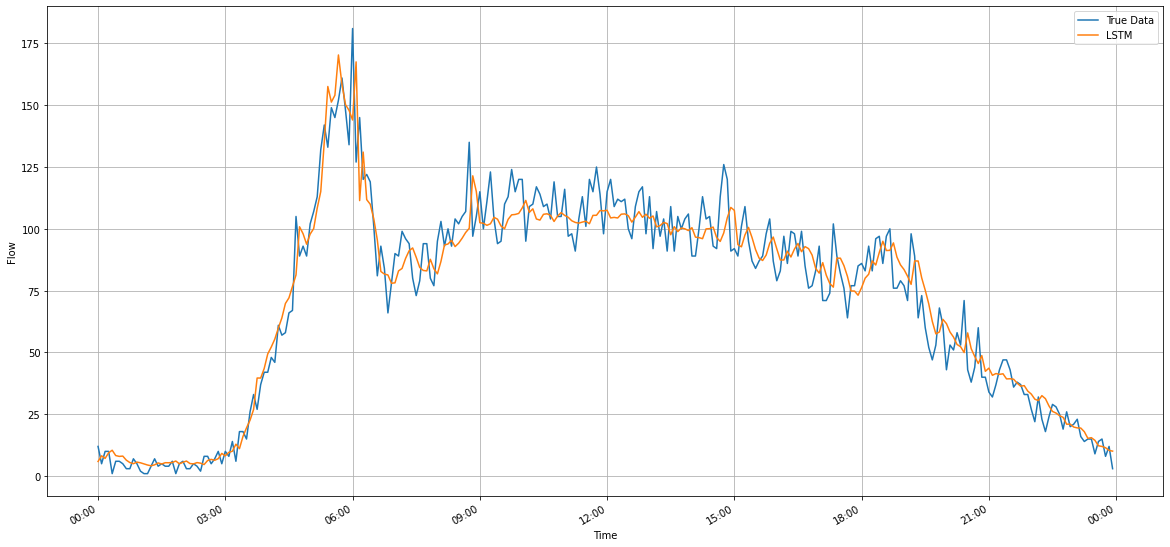

In [36]:
plot_LSTM_oneDay(y_test[: 288],y_preds[: 288])  

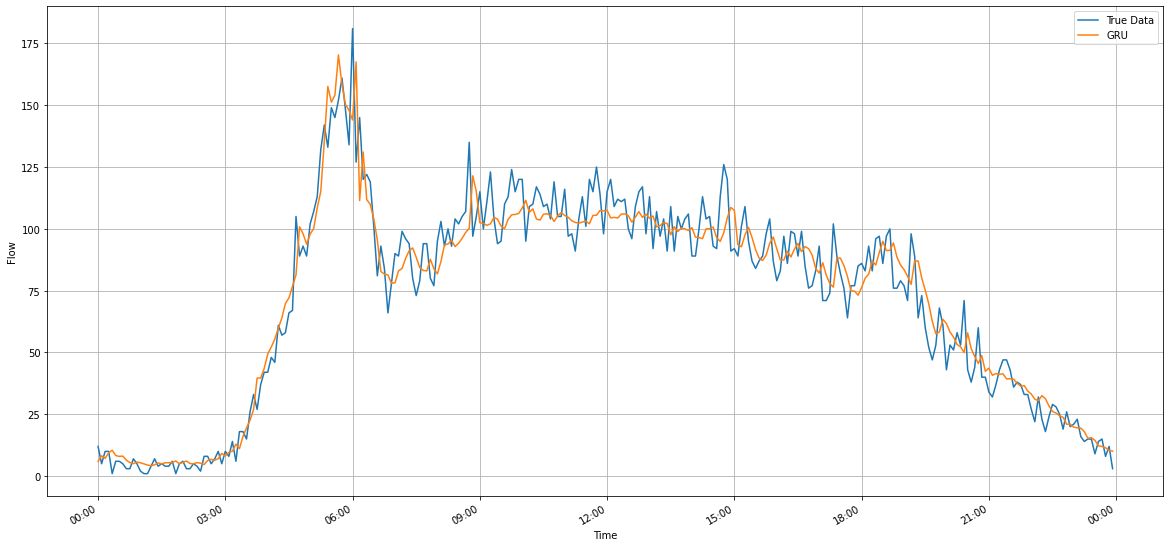

In [37]:
plot_GRU_oneDay(y_test[: 288],y_preds[: 288])  

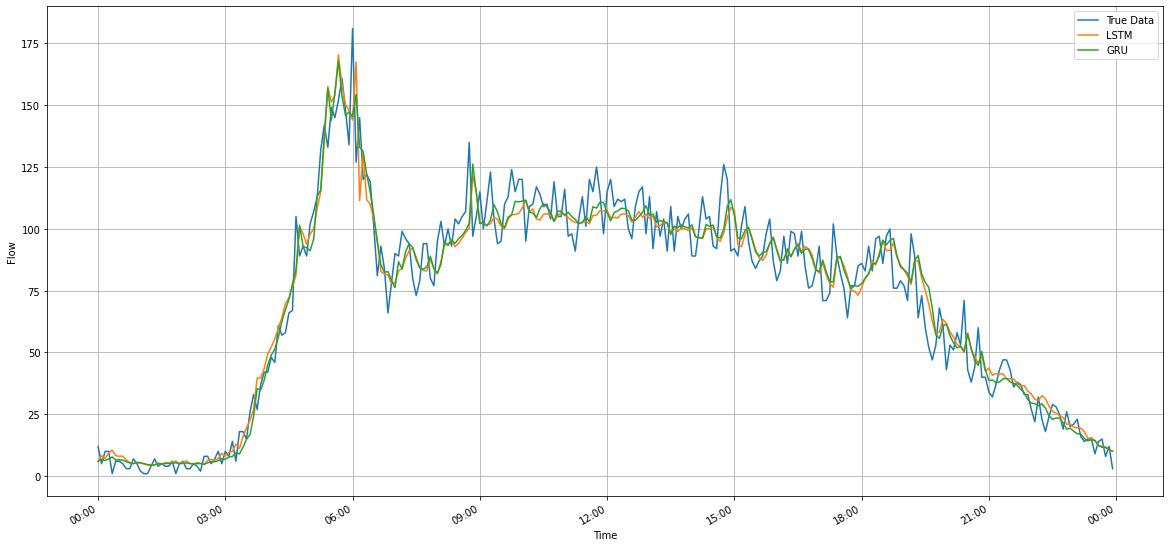

In [38]:
plot_models_oneDay(y_test[: 288],y_preds[: 288])  

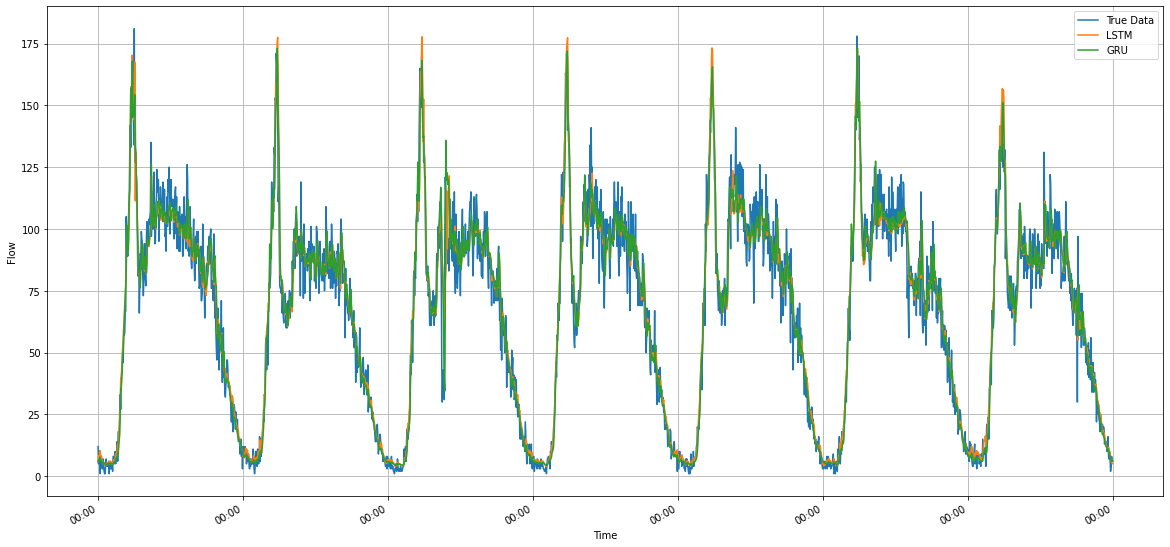

In [39]:
plot_models_oneWeek(y_test[: 2017],y_preds[: 2017])  

In [23]:
x=df2.loc[df2['5 Minutes'] =="11/3/2020 11:30"] 
true = x["Flow (Veh/5 Minutes)"].values
true[0]


106

In [15]:
# 1578.shape

(4308,)

In [17]:
predicted[1578].astype(int)

104